In [9]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [28]:
def task(env, server, processing_time, waiting_time):
    """task arrives, is served and leaves."""
    arrive = env.now
    with server.request() as req:
        yield req
        waiting_time.append(env.now-arrive)
        #print('Task %s arrived at: %7.4f: ' % (arrive))
        yield env.timeout(processing_time)
        #print('Task %s finished at %s' % (env.now))

In [68]:
class Setup(object):
    def __init__(self, env, arrival_rate, processing_capacity, server, waiting_times, desired_var):
        self.env = env
        self.arrival_rate = arrival_rate
        self.processing_capacity = processing_capacity
        self.server = server
        self.waiting_times = waiting_times
        self.converged = env.event()
        self.desired_var = desired_var
        self.action = env.process(self.run())
    
    def run(self):
        while True:
            if  len(self.waiting_times)>1000:
                waiting_rate = 1/np.mean(self.waiting_times)
                var = 1/(len(self.waiting_times)*waiting_rate**2)
                if var < self.desired_var:
                    self.converged.succeed()
                    self.converged = self.env.event()
                    
            arrival_time = random.expovariate(self.arrival_rate)
            yield env.timeout(arrival_time)

            processing_time = random.expovariate(self.processing_capacity)
            env.process(task(self.env, self.server, processing_time, waiting_times))

66.84653339003606 0.4559652067617556
999998.9999712444


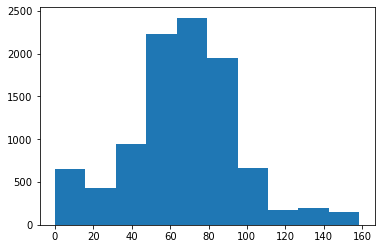

In [16]:
plt.hist(waitingtimes)
mean = np.mean(waitingtimes)
var = 1/(len(waitingtimes)*mean**-2)
print(mean, var)
print((server_util/capacity)/(1-server_util))

In [79]:
n_steps = 5
n_servers = 1
arrival_rate = 1
init_util = 0.7
server_util = np.linspace(init_util, 0.9, n_steps)
processing_capacity = arrival_rate/server_util
desired_var = 0.001
n_samples = np.zeros(n_steps)
for i in tqdm(range(n_steps), desc='calculate number of samples'):
    env = simpy.Environment()
    servers = simpy.Resource(env, capacity=n_servers)
    waiting_times = []
    setup = Setup(env, arrival_rate, processing_capacity[i], servers, waiting_times, desired_var)
    env.run(until=setup.converged)
    n_samples[i] = len(setup.waiting_times)

calculate number of samples: 100%|███████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.62it/s]


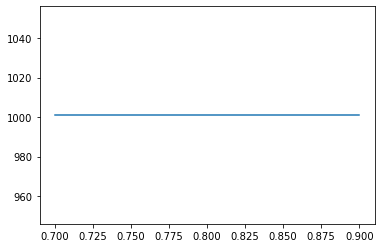

In [80]:
plt.plot(server_util,n_samples)